In [1]:
import yt
import sys

## Load the FLASH file

In [2]:
ds = yt.load("../../TDE_plot/multitidal_hdf5_plt_cnt_0015")
ds

yt : [INFO     ] 2020-11-02 10:25:10,096 Parameters: current_time              = 30252.460515426086
yt : [INFO     ] 2020-11-02 10:25:10,097 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2020-11-02 10:25:10,098 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-11-02 10:25:10,099 Parameters: domain_right_edge         = [7.240177e+13 7.240177e+13 3.620088e+13]
yt : [INFO     ] 2020-11-02 10:25:10,102 Parameters: cosmological_simulation   = 0.0


multitidal_hdf5_plt_cnt_0015

In [3]:
ds.print_stats()

/Users/chang/opt/anaconda3/lib/python3.8/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ret = super(YTArray, self).__getitem__(item)
/Users/chang/opt/anaconda3/lib/python3.8/site-packages/yt/fields/fluid_fields.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_field[slice_3d] = f


level	# grids	       # cells	     # cells^3
----------------------------------------------
  0	     1	           512	             8
  1	     8	          4096	            16
  2	    64	         32768	            32
  3	   512	        262144	            64
  4	   512	        262144	            64
  5	   512	        262144	            64
  6	   512	        262144	            64
  7	   512	        262144	            64
  8	   512	        262144	            64
  9	   512	        262144	            64
 10	   768	        393216	            74
 11	  1408	        720896	            90
----------------------------------------------
   	  5833	       2986496


t = 3.02524605e+04 = 3.02524605e+04 s = 9.58642625e-04 years

Smallest Cell:
	Width: 1.432e-15 Mpc
	Width: 1.432e-09 pc
	Width: 2.954e-04 AU
	Width: 4.419e+09 cm


## Basic Information
### Statistics about the simulation
- Original
- Derived

In [4]:
ds.field_list

[('all', 'particle_accr_rate'),
 ('all', 'particle_accx'),
 ('all', 'particle_accy'),
 ('all', 'particle_accz'),
 ('all', 'particle_blk'),
 ('all', 'particle_creation_time'),
 ('all', 'particle_dtold'),
 ('all', 'particle_gpot'),
 ('all', 'particle_mass'),
 ('all', 'particle_oacx'),
 ('all', 'particle_oacy'),
 ('all', 'particle_oacz'),
 ('all', 'particle_old_pmass'),
 ('all', 'particle_posx'),
 ('all', 'particle_posy'),
 ('all', 'particle_posz'),
 ('all', 'particle_proc'),
 ('all', 'particle_tag'),
 ('all', 'particle_velx'),
 ('all', 'particle_vely'),
 ('all', 'particle_velz'),
 ('all', 'particle_x_ang'),
 ('all', 'particle_x_ang_old'),
 ('all', 'particle_y_ang'),
 ('all', 'particle_y_ang_old'),
 ('all', 'particle_z_ang'),
 ('all', 'particle_z_ang_old'),
 ('flash', 'c12 '),
 ('flash', 'dens'),
 ('flash', 'h1  '),
 ('flash', 'he4 '),
 ('flash', 'temp'),
 ('flash', 'velx'),
 ('flash', 'vely'),
 ('flash', 'velz'),
 ('io', 'particle_accr_rate'),
 ('io', 'particle_accx'),
 ('io', 'particle_

In [5]:
ds.derived_field_list

[('all', 'mesh_id'),
 ('all', 'particle_accr_rate'),
 ('all', 'particle_accx'),
 ('all', 'particle_accy'),
 ('all', 'particle_accz'),
 ('all', 'particle_angular_momentum'),
 ('all', 'particle_angular_momentum_magnitude'),
 ('all', 'particle_angular_momentum_x'),
 ('all', 'particle_angular_momentum_y'),
 ('all', 'particle_angular_momentum_z'),
 ('all', 'particle_blk'),
 ('all', 'particle_creation_time'),
 ('all', 'particle_cylindrical_velocity_theta'),
 ('all', 'particle_cylindrical_velocity_z'),
 ('all', 'particle_dtold'),
 ('all', 'particle_gpot'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_oacx'),
 ('all', 'particle_oacy'),
 ('all', 'particle_oacz'),
 ('all', 'particle_old_pmass'),
 ('all', 'particle_ones'),
 ('all', 'particle_position'),
 ('all', 'particle_position_cylindrical_radius'),
 ('all', 'particle_position_cylindrical_theta'),
 ('all', 'particle_position_cylindrical_z'),
 ('all', 'particle_position_relative'),
 ('all', 'particle_position_relati

### Domain of the simulation

In [6]:
ds.domain_width.in_units("au")

YTArray([4.83975939, 4.83975939, 2.41987936]) au

## Simple Visualization
### Projection
- A line integral through the domain

yt : [INFO     ] 2020-11-02 10:25:45,098 Projection completed
yt : [INFO     ] 2020-11-02 10:25:45,099 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-11-02 10:25:45,099 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-11-02 10:25:45,102 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-11-02 10:25:45,104 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-11-02 10:25:45,107 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2020-11-02 10:25:45,121 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



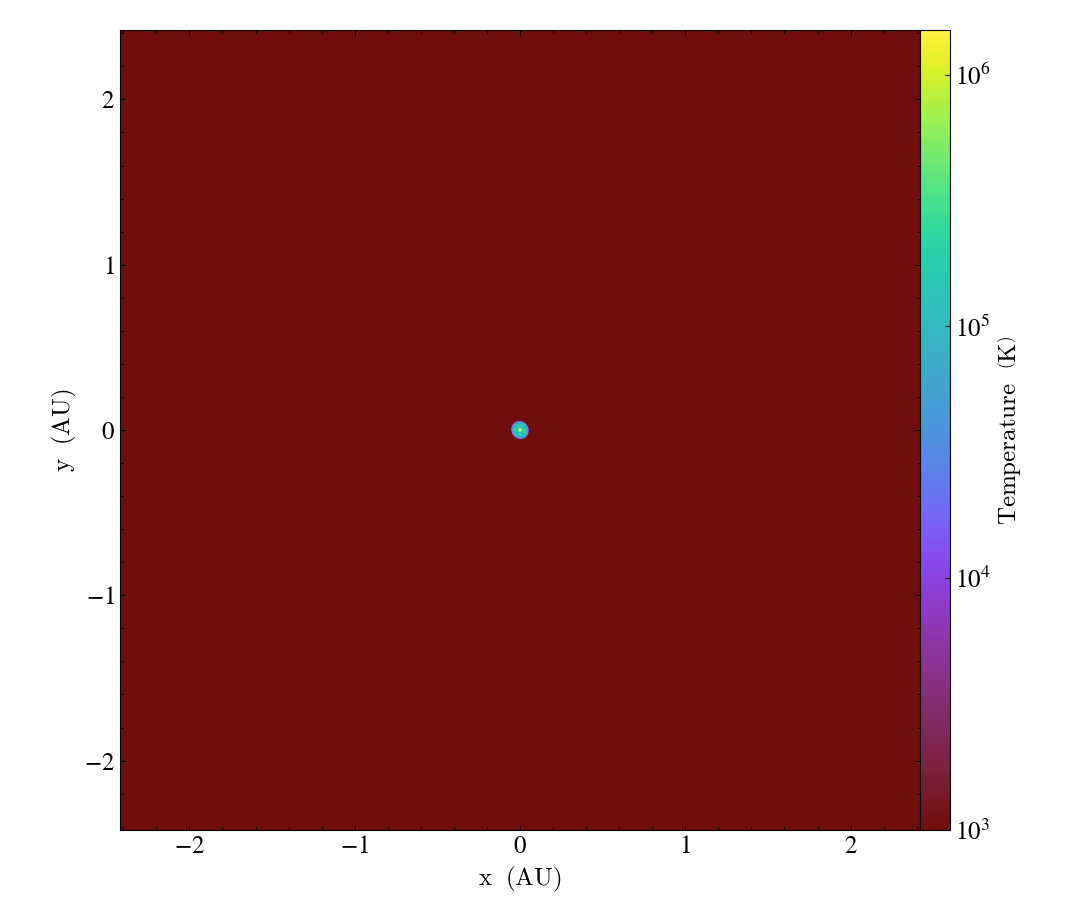
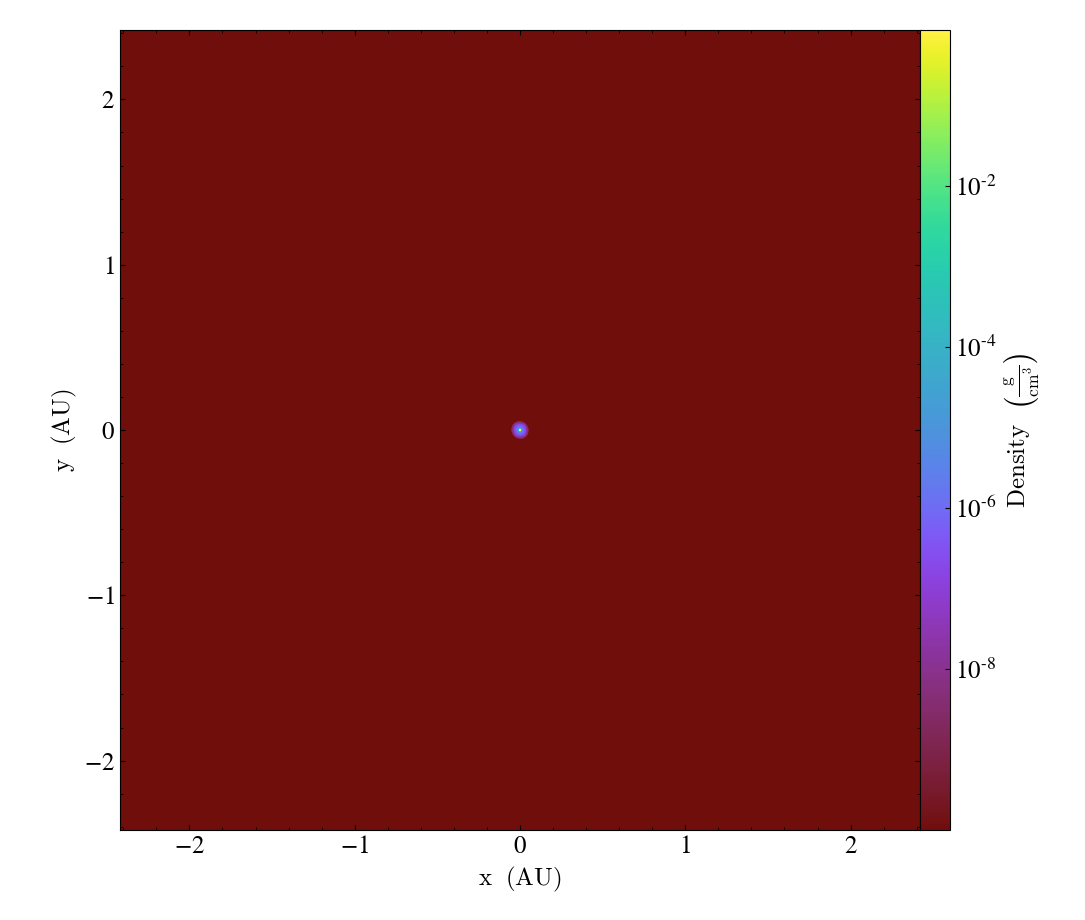

In [9]:
pp = yt.ProjectionPlot(ds, "z", ["density", "temperature"], weight_field="density")
pp

yt : [INFO     ] 2020-11-02 10:25:49,203 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2020-11-02 10:25:49,217 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



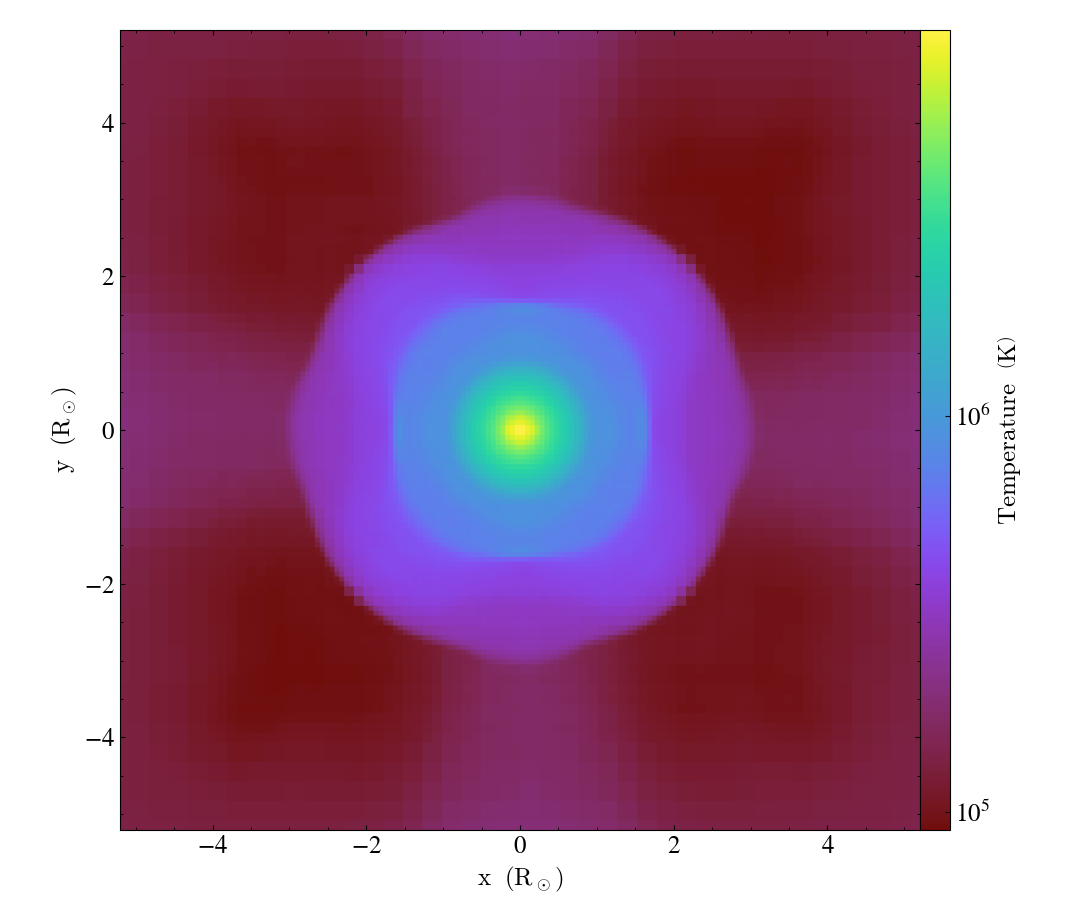
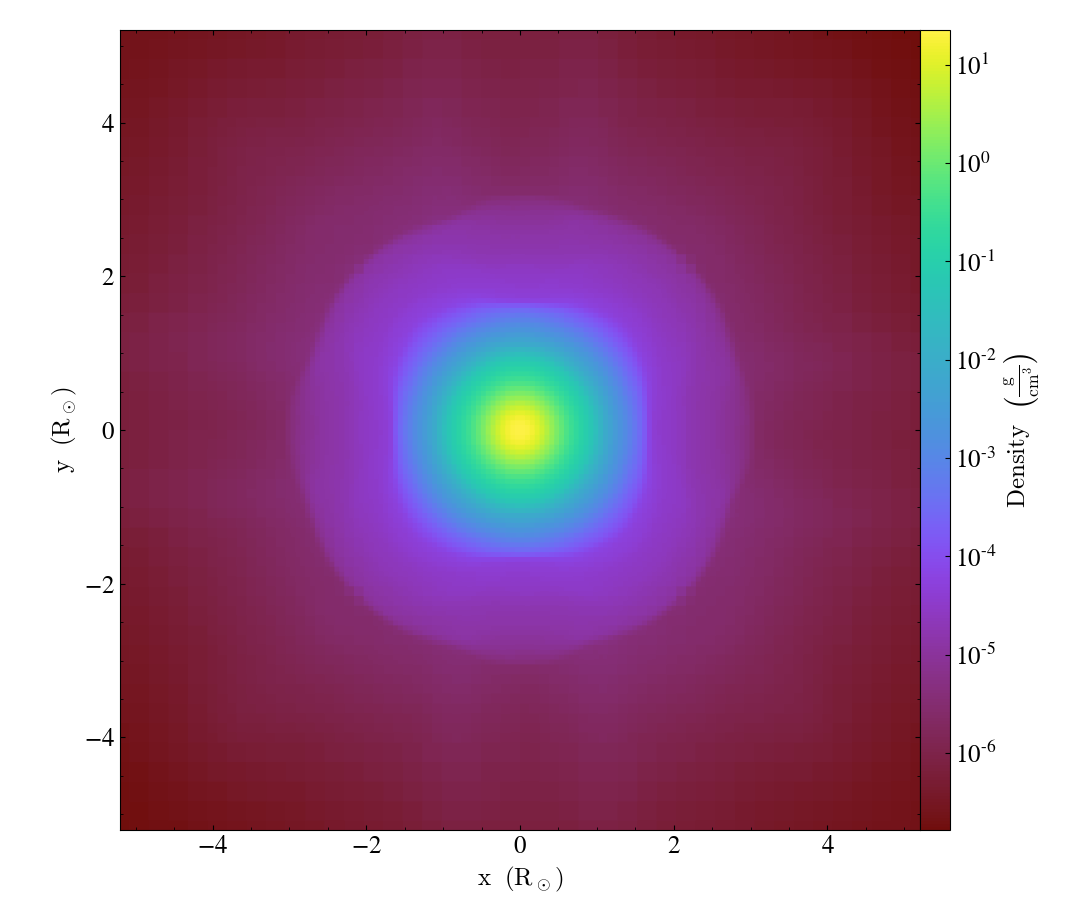

In [10]:
pp.zoom(100)